In [1]:
import investpy as ipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from scipy.stats import skew,kurtosis,jarque_bera
from scipy.optimize import minimize

In [2]:
tickers = ['ADBE','EPAM','FB','INTU','MSFT','NVDA','PYPL']

In [3]:
def get_return(tickers:list,start_data:str,end_date:str)->pd.DataFrame:
    agg_dataframe = pd.DataFrame()
    for ticker in tickers:
        data = ipy.get_stock_historical_data(stock=ticker,country='United States',from_date=start_data,to_date=end_date)
        agg_dataframe[ticker] = data['Close']
    daily_returns = agg_dataframe.pct_change()
    daily_returns = daily_returns.dropna()
    return (daily_returns,agg_dataframe)

In [4]:
returns,data = get_return(tickers,'01/01/2010','12/08/2021')

In [18]:
data_mon = data.resample('M').last()

In [19]:
data_year=data.resample('Y').last().pct_change().dropna()
data_year.describe()

,ADBE,EPAM,FB,INTU,MSFT,NVDA,PYPL
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.388617,0.461023,0.266687,0.334378,0.325003,0.874567,0.453615
std,0.214050,0.409351,0.306912,0.100527,0.156966,0.838966,0.449801
min,0.095912,-0.182015,-0.257112,0.187668,0.120043,-0.310045,0.090331
25%,0.274054,0.227525,0.156358,0.268369,0.216295,0.584136,0.149777
50%,0.374409,0.675212,0.329237,0.353638,0.339777,0.787888,0.229410
75%,0.501738,0.686772,0.483042,0.404296,0.401942,1.117665,0.720501
max,0.702186,0.828808,0.565718,0.450197,0.552624,2.237864,1.165110


In [20]:
return_mon = data_mon.pct_change().dropna()


In [21]:
annualized_return = data_mon.pct_change().dropna()

In [23]:
annualized_return = (1+return_mon).prod()**(12/return_mon.shape[0])-1

In [17]:
annualized_return

ADBE    0.399709
EPAM    0.412286
FB      0.248629
INTU    0.306228
MSFT    0.349728
NVDA    0.833711
PYPL    0.380386
dtype: float64

w1*return_ass1+w2*return_ass2+....wn*return_assn

In [24]:
cov_matrix = return_mon.cov()

In [25]:
cov_matrix

,ADBE,EPAM,FB,INTU,MSFT,NVDA,PYPL
ADBE,0.003977,0.003091,0.003018,0.002462,0.002465,0.003923,0.002865
EPAM,0.003091,0.006227,0.003269,0.003140,0.002319,0.003055,0.003036
FB,0.003018,0.003269,0.006010,0.002295,0.002267,0.003156,0.003275
INTU,0.002462,0.003140,0.002295,0.004115,0.001994,0.002958,0.002986
MSFT,0.002465,0.002319,0.002267,0.001994,0.002909,0.003047,0.002319
NVDA,0.003923,0.003055,0.003156,0.002958,0.003047,0.014451,0.003205
PYPL,0.002865,0.003036,0.003275,0.002986,0.002319,0.003205,0.006021


In [26]:
def portfolio_return(w,an_return):
    return w.T @ an_return
    

In [27]:
def portfolio_var(w,cov_matrix):
    return (w.T @ cov_matrix @ w)**0.5

# w=np.repeat(1/annualized_return.shape[0],annualized_return.shape[0])
# print(portfolio_var(w,cov_matrix,annualized_return))



In [29]:

def minimize_vol(return_target,an_return,cov_matrix):
    initial_guess=np.repeat(1/annualized_return.shape[0],annualized_return.shape[0])
    bounds=((0,1),)*annualized_return.shape[0]
    is_target={'type':'eq','args':(an_return,),'fun':lambda w,an_return:return_target - portfolio_return(w,an_return)}
    sum_w={'type':'eq','fun':lambda w: 1 - np.sum(w)}
    const=[sum_w,is_target]
    results=minimize(portfolio_var,x0=initial_guess,bounds=bounds,method='SLSQP',constraints=const,options={'disp':False},args=(cov_matrix,))
    return results.x






In [69]:

# for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
#     print([round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)])
print(minimize_vol(0.35,annualized_return,cov_matrix))



[0.12858408 0.01467955 0.02347763 0.20739856 0.59392436 0.00717042
 0.02476539]


<AxesSubplot:xlabel='vol'>

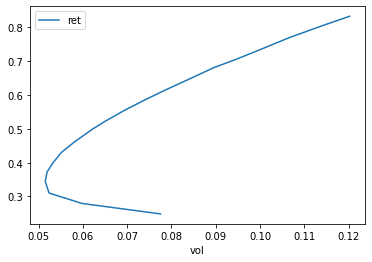

In [67]:
ret=[]
vol=[]
we=[]
for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
    weights = [round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)]
    weights=np.array(weights)
    ret.append(portfolio_return(weights,annualized_return))
    vol.append(portfolio_var(weights,cov_matrix))
    we=weights
pd.DataFrame({'ret':ret,'vol':vol}).plot.line(x='vol',y='ret')



    

In [68]:
for target in np.linspace(annualized_return.min(),annualized_return.max(),20):
    weight = [round(w,2) for w in minimize_vol(target,annualized_return,cov_matrix)]
    print(weight,target)

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] 0.24847635778598987
[0.0, 0.0, 0.51, 0.43, 0.06, 0.0, 0.0] 0.27923917672848847
[0.0, 0.0, 0.25, 0.33, 0.42, 0.0, 0.0] 0.31000199567098713
[0.09, 0.01, 0.04, 0.25, 0.6, 0.0, 0.02] 0.34076481461348573
[0.14, 0.04, 0.0, 0.17, 0.58, 0.04, 0.03] 0.3715276335559844
[0.13, 0.07, 0.0, 0.12, 0.54, 0.09, 0.05] 0.402290452498483
[0.13, 0.09, 0.0, 0.06, 0.5, 0.15, 0.06] 0.4330532714409816
[0.13, 0.12, 0.0, 0.01, 0.46, 0.2, 0.08] 0.46381609038348026
[0.1, 0.14, 0.0, 0.0, 0.42, 0.27, 0.08] 0.49457890932597887
[0.09, 0.15, 0.0, 0.0, 0.35, 0.33, 0.07] 0.5253417282684775
[0.08, 0.17, 0.0, 0.0, 0.29, 0.39, 0.07] 0.5561045472109761
[0.06, 0.19, 0.0, 0.0, 0.23, 0.46, 0.06] 0.5868673661534747
[0.1, 0.21, 0.0, 0.0, 0.12, 0.51, 0.06] 0.6176301850959733
[0.08, 0.22, 0.0, 0.0, 0.07, 0.58, 0.05] 0.648393004038472
[0.06, 0.24, 0.0, 0.0, 0.02, 0.64, 0.05] 0.6791558229809707
[0.0, 0.24, 0.0, 0.0, 0.0, 0.71, 0.04] 0.7099186419234693
[0.0, 0.21, 0.0, 0.0, 0.0, 0.78, 0.0] 0.7406814

In [72]:
(190**4 - 120/0.3)*1780

2319713088000.0

In [93]:
print(range(2,20))


range(2, 20)


In [91]:
x

range(2, 20)

# TEXT